In [1]:
import csv
import pandas as pd
import xgboost as xgb
from matplotlib import pyplot as plt
import math
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

import pickle

#matplotlibの日本語文字化けを避ける設定
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Hiragino Maru Gothic Pro', 'Yu Gothic', 'Meirio', 'Takao', 'IPAexGothic', 'IPAPGothic', 'VL PGothic', 'Noto Sans CJK JP']

In [2]:
with open("train_processed.csv",'r',newline='',encoding="utf_8_sig") as inputfile: #改行コードがあることを明示,BOM付きファイル削除
    #DataFrameを作成。pandasuはread_csv()がカンマ区切り、read_table()がタブ区切りを読み込む
    train_data = pd.read_csv(inputfile)
    #header : ヘッダーがないのでNoneを指定。あれば0を指定（指定しないと１行目は勝手にヘッダー扱いになる）、
    #name : 適当に名前を付与
    #index_col : 行番号をindexに指定
    #usecols ：CSVの読み込み対象とする列を指定するprint("dfタイプ：", type(df))
print("\nサンプル表示\n")
train_data[0:1]


サンプル表示



,賃料,area,buildage,contract_period,シャワー,トイレなし,バスなし,バス・トイレ別,共同トイレ,共同バス,...,2LDK,3DK,3K,3LDK,4DK,4K,4LDK,5DK,5LDK,6LDK
0,75000,20.01,9.75,2.0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
# 2列目以降を特徴量として使う
x = train_data.iloc[:, 1:]
# 確認 :
print('Feature data :', x[0:1])

Feature data :     area  buildage  contract_period  シャワー  トイレなし  バスなし  バス・トイレ別  共同トイレ  共同バス  \
0  20.01      9.75              2.0     1      0     0        1      0     0   

   専用トイレ  ...  2LDK  3DK  3K  3LDK  4DK  4K  4LDK  5DK  5LDK  6LDK  
0      1  ...     0    0   0     0    0   0     0    0     0     0  

[1 rows x 109 columns]


In [4]:
# 0列目が正解ラベル
y = train_data.iloc[:, 0]
# 確認 :
print('answer :', y)

answer : 0         75000
1         76000
2        110000
3        150000
4         74000
          ...  
31465     80000
31466     54500
31467    125000
31468     98000
31469     81000
Name: 賃料, Length: 31470, dtype: int64


x_train.shape :  (25176, 109)
x_test.shape :  (6294, 109)
y_train.shape :  (25176,)
y_test.shape :  (6294,)
[05:08:29] WARNING: /private/var/folders/v7/c3_jj7v17v9_prw7wrf_qwb80000gn/T/pip-install-2q9xix17/xgboost/xgboost/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:101446.33594	eval-rmse:100145.92969
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 10 rounds.
[1]	train-rmse:75249.58594	eval-rmse:74448.57031
[2]	train-rmse:57455.44141	eval-rmse:57521.68359
[3]	train-rmse:45712.87500	eval-rmse:46224.34375
[4]	train-rmse:38218.66406	eval-rmse:39594.14844
[5]	train-rmse:33254.51172	eval-rmse:35193.03516
[6]	train-rmse:30211.15039	eval-rmse:32737.25977
[7]	train-rmse:28320.03125	eval-rmse:31290.98828
[8]	train-rmse:26960.83984	eval-rmse:30361.76953
[9]	train-rmse:26162.15820	eval-rmse:29798.18164
[10]	train-rmse:25533.06836	eval-rmse:29459.054

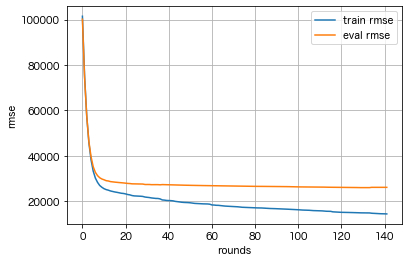

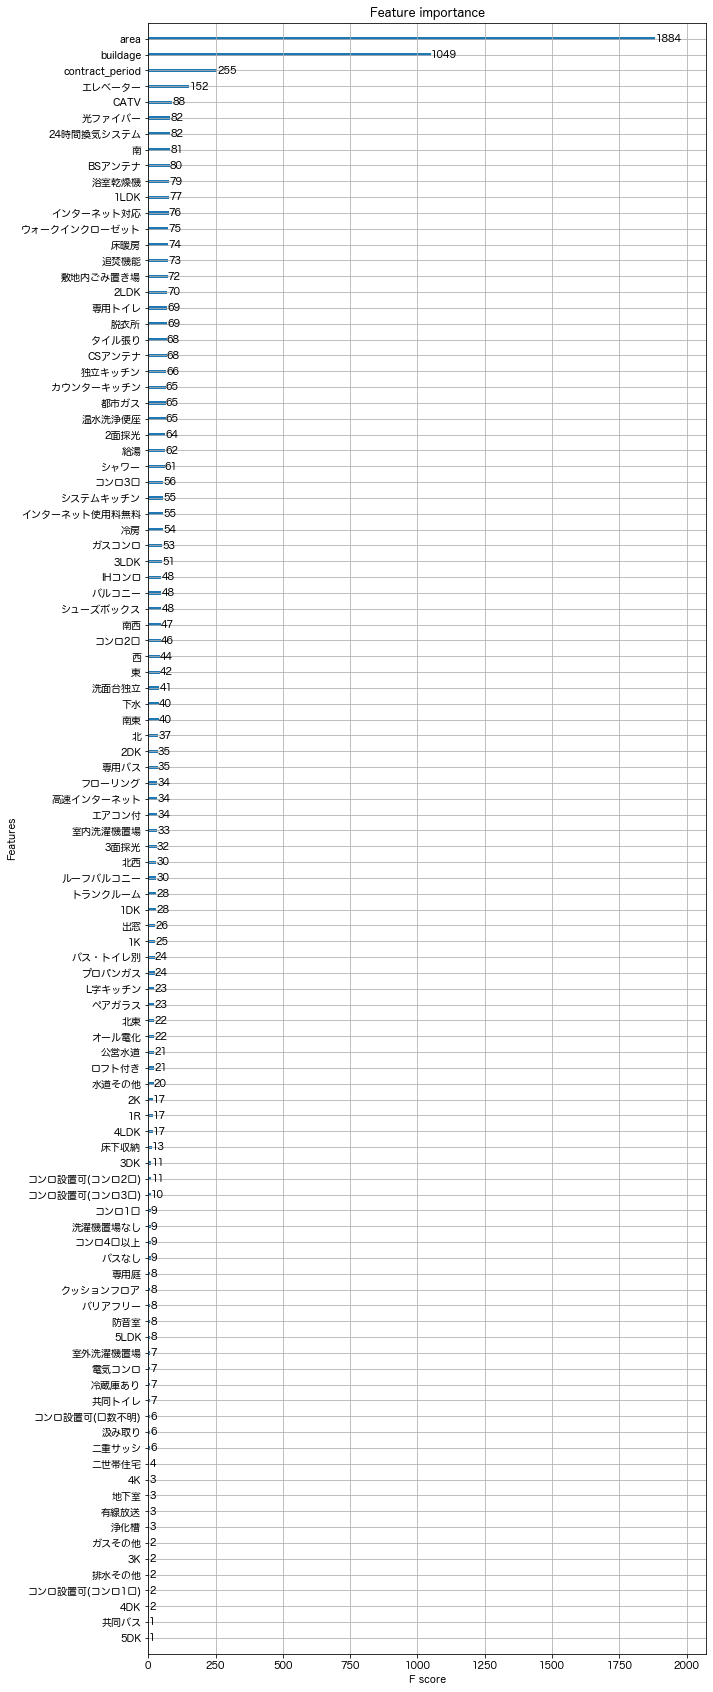

In [20]:
# データセットを学習用と検証用に分割する
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=True, random_state=42)

print("x_train.shape : ", x_train.shape)
print("x_test.shape : ", x_test.shape)
print("y_train.shape : ", y_train.shape)
print("y_test.shape : ", y_test.shape)

# XGBoost が扱うデータセットの形式に直す
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)

# 学習用のパラメータ
xgb_params = {
    # 二値分類問題
    #'objective': 'binary:logistic',
    # 回帰問題
    'objective': 'reg:linear',
    # 評価指標
    #'eval_metric': 'logloss',
    # 学習用の指標（RMSE）
    'eval_metric': 'rmse',
}

# モデルを学習する
evals = [(dtrain, 'train'), (dtest, 'eval')]
evals_result = {}
bst = xgb.train(xgb_params,dtrain,num_boost_round=1000,early_stopping_rounds=10,evals=evals,evals_result=evals_result)

# 検証用データのRMSEを計算する
y_pred = bst.predict(dtest)
mse = mean_squared_error(y_test, y_pred)
print('RMSE:', math.sqrt(mse))

train_metric = evals_result['train']['rmse']
plt.plot(train_metric, label='train rmse')
eval_metric = evals_result['eval']['rmse']
plt.plot(eval_metric, label='eval rmse')
plt.grid()
plt.legend()
plt.xlabel('rounds')
plt.ylabel('rmse')
plt.show()

#imprtanceの出力
_, ax = plt.subplots(figsize=(10, 30))
xgb.plot_importance(bst,
                    ax=ax,
                    importance_type='weight',
                    #show_values=False
                   )
plt.show()

#### 結果
 - train8割
     - RMSE: 26114.598555098066
     - importance
         - area:1884
         - buildage:1049
         - contract_period:255
         - エレベーター:152
         - CATV:88
 - train7割
 RMSE: 28907.154360164055

In [7]:
pickle.dump(bst, open("xgb_model.pickle", "wb"))